Number of images:  33180


<function matplotlib.pyplot.show(*args, **kw)>

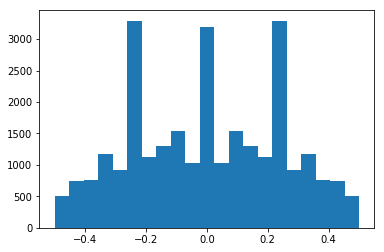

In [10]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

images = []
measurements = []

# Select which datasets to use for training
# Thought about making this automatic, but wanted ability to select individual datasets
datasets = ['Train1', 'Train4', 'Train6', 'Train7']#, 'Train2', 'Train4', 'Train5']


# Loop thorugh selected datasets
for dataset in datasets:
    lines = []
    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    # Center, Left, Right
    steer_correct = [0, 0.25, -0.25]
    for line in lines:
        for i in range(3): #center, left, right
            sourcepath = line[i]
            
            # Have to account for data captured on both my Mac and Windows machines 
            # (i.e.: path on windows has backslashes)
            if("/" in sourcepath):
                filename = sourcepath.split('/')[-1]
            else:
                filename = sourcepath.split('\\')[-1]
                                            
            currentpath = 'data/' + dataset + '/' + filename
            image = cv2.imread(currentpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) # Suggested by nvidia
            images.append(image)
            images.append(cv2.flip(image,1)) #Flip image
            measurement = float(line[3]) + steer_correct[i]
            measurements.append(measurement)
            measurements.append(-measurement)
            
X_train_raw = np.array(images)
y_train_raw = np.array(measurements)

print("Number of images: ", len(y_train_raw))

plt.figure()
plt.hist(y_train_raw, bins=21, range=(-0.5, 0.5))
plt.show

0
4
-8
-6
8
-11
0
8
-8
0
8
-8
-4
7
-8
0
6
-8
0
8


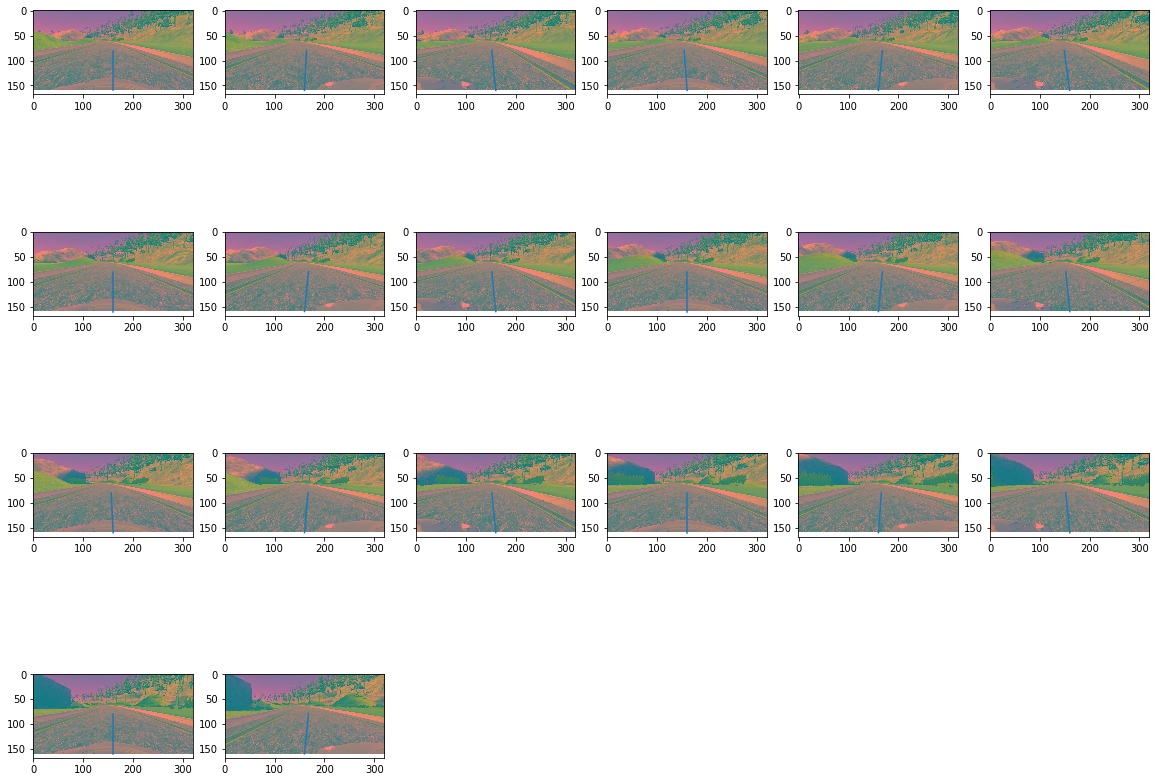

In [11]:
import math


def plot_imgs(X, y=np.array([]), cols = 6, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    shp = X[0].shape
    
    plotNum = 1
    plt.figure(figsize = (20, num_rows*4))
    for i in range(num_plots):
        
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(X[i], cmap=cmap)
        if(len(y) > 0):
            #Generate a line to plot
            #print(y[i])
            steer_angle = y[i]*25*math.pi/180 #steer value of 1 maps to 25% steering angle
            offst = np.int(math.atan(steer_angle)*shp[0]/2)
            #print(offst)
            xpnts = (math.ceil(shp[1]/2)+offst, shp[1]/2)
            ypnts = (math.ceil(shp[0]/2), shp[0])
            plt.plot(xpnts, ypnts, '-')
        plotNum = plotNum + 1


test_imgs = np.arange(0, 1000, 50)
#test_imgs = [0,1,2,3,4,5]
plot_imgs(X_train_raw[test_imgs], y_train_raw[test_imgs])    

(0, 160, 320, 3)
(0, 160, 320, 3)
(33180, 160, 320, 3)
(33180, 160, 320, 3)


<function matplotlib.pyplot.show(*args, **kw)>

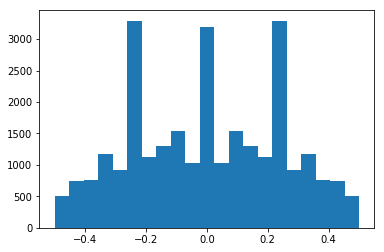

In [14]:
# Filter data - need to move this before data/steering augmentation...
steer_angle_thresh = 0.04
X_train = X_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]
y_train = y_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]

X_train_straight = X_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]
y_train_straight = y_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]

print (X_train_straight.shape)
# Grab 33% of straight data
X_train_straight = X_train_straight[np.arange(0, len(y_train_straight)-1, 3)]
y_train_straight = y_train_straight[np.arange(0, len(y_train_straight)-1, 3)]

print (X_train_straight.shape)

X_train = np.append(X_train, X_train_straight, axis=0)
y_train = np.append(y_train, y_train_straight, axis=0)

print(X_train_raw.shape)
print(X_train.shape)

plt.figure()
plt.hist(y_train, bins=21, range=(-0.5, 0.5))
plt.show


In [15]:
## Set Up NNs ##
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout


dropout = [0.0, 0.3, 0.3, 0.5]


def LeNet1():
	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(10, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Convolution2D(20, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Flatten())
	model.add(Dense(120))
	model.add(Dense(84))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7, batch_size=128)

	model.save('model.h5')

def nvidia():

	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#78x158
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#37x77
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#16x36
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 5, 5, subsample=(2,2), activation='relu'))#2x17
	model.add(Dropout(dropout[1]))
	#model.add(Convolution2D(64, 5, 5, subsample=(2,1), activation='relu'))#1x12
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=256)

	model.save('model.h5')

def nvidia1():

	model = Sequential()
	model.add(Cropping2D(cropping=((74,20), (60,60)), input_shape=(160, 320, 3))) # 66, 200
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#31x98
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#14X47
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#5x22
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#3x20
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#1x18
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dropout(dropout[3]))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=128)

	model.save('model.h5')

def nvidia2():

	model = Sequential()
	model.add(Cropping2D(cropping=((74,20), (40,40)), input_shape=(160, 320, 3))) # 66, 200
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#31x98
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#14X47
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#5x22
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#3x20
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#1x18
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dropout(dropout[3]))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=128)

	model.save('model.h5')


nvidia1()

Train on 26544 samples, validate on 6636 samples
Epoch 1/3
26544/26544 [==============================] - 103s - loss: 0.0381 - val_loss: 0.0912
Epoch 2/3
26544/26544 [==============================] - 86s - loss: 0.0215 - val_loss: 0.0680
Epoch 3/3
26544/26544 [==============================] - 87s - loss: 0.0192 - val_loss: 0.0786
